In [15]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 데이터 확인

In [16]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [17]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [18]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [19]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [31]:
print(index_to_word.keys())

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [34]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])     # '<PAD>' 가 출력됩니다. 
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(X_train[0], index_to_word))

<PAD>
<BOS>
1 뭔지 <UNK> <UNK> 음 마음 .. 너무 티


## 모델 구성을 위한 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [22]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [36]:
import tensorflow as tf


X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 모델 구성 및 훈련

### 1. RNN 모델

In [37]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 653,505
Trainable params: 653,505
Non-trainable params: 0
_________________________________________________________________


In [39]:
# validation set 10000건 분리
X_val = X_train[:15000]   
y_val = y_train[:15000]

# validation set을 제외한 나머지 
partial_X_train = X_train[15000:]  
partial_y_train = y_train[15000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(131182, 41)
(131182,)


In [50]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
257/257 [==============================] - 3s 8ms/step - loss: 0.0697 - accuracy: 0.9727 - val_loss: 1.0372 - val_accuracy: 0.8384
Epoch 2/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0604 - accuracy: 0.9762 - val_loss: 1.1292 - val_accuracy: 0.8367
Epoch 3/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0578 - accuracy: 0.9780 - val_loss: 1.1119 - val_accuracy: 0.8375
Epoch 4/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0559 - accuracy: 0.9783 - val_loss: 1.2352 - val_accuracy: 0.8371


In [51]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0310 - accuracy: 0.8346
[1.031043291091919, 0.8345504999160767]


In [52]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


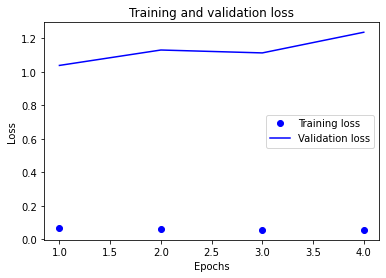

In [53]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

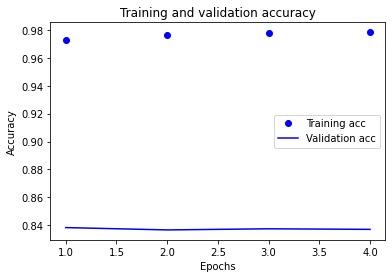

In [54]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 2. CNN 모델

In [55]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [56]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
257/257 [==============================] - 1s 4ms/step - loss: 0.5664 - accuracy: 0.7428 - val_loss: 0.4106 - val_accuracy: 0.8262
Epoch 2/20
257/257 [==============================] - 1s 3ms/step - loss: 0.3688 - accuracy: 0.8430 - val_loss: 0.3548 - val_accuracy: 0.8413
Epoch 3/20
257/257 [==============================] - 1s 3ms/step - loss: 0.3236 - accuracy: 0.8632 - val_loss: 0.3463 - val_accuracy: 0.8454
Epoch 4/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2986 - accuracy: 0.8756 - val_loss: 0.3465 - val_accuracy: 0.8449
Epoch 5/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2801 - accuracy: 0.8847 - val_loss: 0.3511 - val_accuracy: 0.8457
Epoch 6/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2651 - accuracy: 0.8922 - val_loss: 0.3573 - val_accuracy: 0.8439


In [57]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3594 - accuracy: 0.8433
[0.35936209559440613, 0.843338668346405]


In [58]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


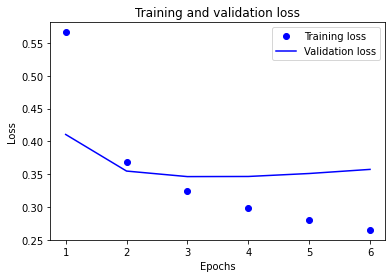

In [59]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

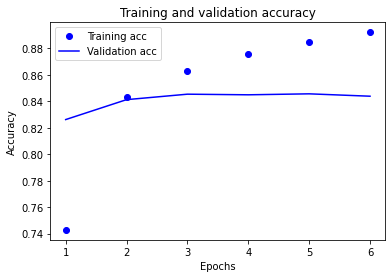

In [60]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 3. Transformer 모델

In [61]:
import tensorflow as tf

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 어휘 사전 크기 및 모델 설정
vocab_size = 10000  # 기존 RNN, CNN 실험과 동일
word_vector_dim = 16  # 기존 실험과 동일한 임베딩 차원
maxlen = 41  # 시퀀스 길이

embed_dim = word_vector_dim  # 임베딩 차원 (Transformer는 동일한 차원 사용)
num_heads = 2  # Multi-Head Attention 개수
ff_dim = 32  # Feed Forward Network 차원

# 모델 구성
inputs = tf.keras.layers.Input(shape=(maxlen,))
embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=maxlen)(inputs)

# Transformer 블록 추가
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(embedding_layer)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# 모델 정의
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
transformer_block (Transform (None, 41, 16)            3296      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 163,585
Trainable params: 163,585
Non-trainable params: 0
_______________________________________________________

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    partial_X_train,
    partial_y_train,
    epochs=20,
    batch_size=512,  
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  # EarlyStopping 적용
    verbose=1
)


Epoch 1/20
257/257 [==============================] - 4s 9ms/step - loss: 0.4453 - accuracy: 0.7876 - auc: 0.8738 - val_loss: 0.3675 - val_accuracy: 0.8371 - val_auc: 0.9165
Epoch 2/20
257/257 [==============================] - 2s 7ms/step - loss: 0.3477 - accuracy: 0.8485 - auc: 0.9256 - val_loss: 0.3615 - val_accuracy: 0.8393 - val_auc: 0.9196
Epoch 3/20
257/257 [==============================] - 2s 7ms/step - loss: 0.3227 - accuracy: 0.8619 - auc: 0.9362 - val_loss: 0.3621 - val_accuracy: 0.8415 - val_auc: 0.9214
Epoch 4/20
257/257 [==============================] - 2s 7ms/step - loss: 0.3056 - accuracy: 0.8710 - auc: 0.9429 - val_loss: 0.3593 - val_accuracy: 0.8425 - val_auc: 0.9224
Epoch 5/20
257/257 [==============================] - 2s 8ms/step - loss: 0.2930 - accuracy: 0.8775 - auc: 0.9475 - val_loss: 0.3648 - val_accuracy: 0.8415 - val_auc: 0.9220
Epoch 6/20
257/257 [==============================] - 2s 7ms/step - loss: 0.2807 - accuracy: 0.8827 - auc: 0.9519 - val_loss: 0.36

In [64]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3724 - accuracy: 0.8410 - auc: 0.9173
[0.372440367937088, 0.8409992456436157, 0.9172765612602234]


In [65]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


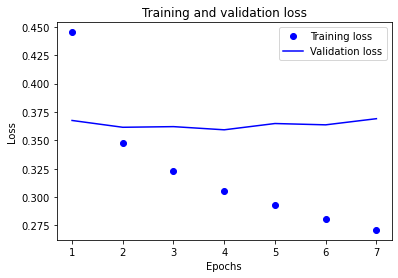

In [66]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

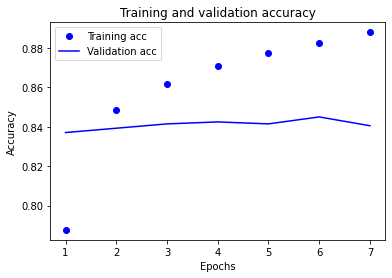

In [67]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### [모델 훈련 시각화 분석]
처음에 RNN을 돌렸을 때 결과를 보고 충격적이었다.

그래도 CNN 결과가 train 그래프와 valid 그래프의 개형이 유사해지는 걸 보고 다행이라는 생각이 들었다.

그래도 loss 가 0.35, acc가 0.84 정도의 결과가 나와서 다소 아쉽긴 하다.

마지막으로 Transformer를 돌렸을 때 acc는 여전히 0.84 정도의 결과가 나왔지만 loss가 0.36~0.37 정도의 결과가 나와서 오히려 CNN의 결과가 현재는 가장 좋은 점이 의외였다.

실험에서 잘못한 부분은 없는지 체크가 필요할 것 같다.

## 학습된 Embedding 레이어 분석

### 1. Embedding 가중치 추출

In [83]:
# 모델의 Embedding 레이어 가져오기
embedding_layer = model.layers[1]  # 모델에서 2번째 레이어가 Embedding임
embedding_weights = embedding_layer.get_weights()[0]  # 가중치 추출

print("Embedding Shape:", embedding_weights.shape)  # (vocab_size, word_vector_dim)


Embedding Shape: (10000, 16)


In [84]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

KeyError: 4

### 2. 특정 단어의 임베딩 벡터 확인

In [69]:
word = "행복"  # 예제 단어
word_index = word_to_index.get(word, 1)  # 존재하지 않으면 <UNK> 사용
print(f"'{word}'의 임베딩 벡터:\n", embedding_weights[word_index])


'행복'의 임베딩 벡터:
 [ 0.01578087  0.05754105 -0.09161827 -0.04542348 -0.0806656   0.02069541
  0.02351934  0.06893668  0.02194176  0.01236382  0.01335607  0.01631638
  0.04247322  0.07663053  0.06306281  0.03745013]


### 3. 유사한 단어 찾기 (코사인 유사도)

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_words(target_word, word_to_index, embedding_weights, top_n=5):
    if target_word not in word_to_index:
        print(f"'{target_word}' 단어가 존재하지 않습니다.")
        return []
    
    target_idx = word_to_index[target_word]
    if target_idx >= embedding_weights.shape[0]:  # 인덱스 초과 방지
        print(f"Error: {target_word}의 인덱스 {target_idx}가 임베딩 가중치 범위를 초과함.")
        return []
    
    target_vector = embedding_weights[target_idx].reshape(1, -1)
    
    similarities = {}
    for word, idx in word_to_index.items():
        if idx >= embedding_weights.shape[0]:  # 인덱스 초과 방지
            continue
        if idx == 0 or idx == 1:  # PAD, UNK 제외
            continue
        word_vector = embedding_weights[idx].reshape(1, -1)
        similarity = cosine_similarity(target_vector, word_vector)[0][0]
        similarities[word] = similarity

    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:top_n]

# 테스트 실행
similar_words = find_similar_words("기쁨", word_to_index, embedding_weights)
print(similar_words)


[('기쁨', 0.99999994), ('악인', 0.8095761), ('어이', 0.77888757), ('노트북', 0.775084), ('알맹이', 0.7573676)]


In [73]:
similar_words = find_similar_words("눈물", word_to_index, embedding_weights)
print(similar_words)

[('눈물', 1.0000001), ('연장', 0.8528804), ('어설펐', 0.8241677), ('편성', 0.8233265), ('릴', 0.81530076)]


In [74]:
similar_words = find_similar_words("싸움", word_to_index, embedding_weights)
print(similar_words)

[('싸움', 1.0), ('겅', 0.87302274), ('아름다워요', 0.8285619), ('감안', 0.8213824), ('.;;', 0.8194434)]


### [Embedding 레이어 분석]
예시로 '기쁨', '눈물', '싸움'으로 유사도 테스트를 해봤는데, 학습이 제대로 이루어지지 않은 것 같습니다.
전혀 상관이 없는 단어들이 유사도 점수가 상당히 높은 것을 확인할 수 있습니다.

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [79]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [80]:
print(vector)

[ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7759619   